# PyTorch ConvNet

Autor: Gabriel Dornelles Monteiro, junho de 2022. Notebook nº5.

Neste notebook, iremos construir utilizando o framework PyTorch, o mesmo modelo que construimos anteriormente com os módulos que desenvolvemos na biblioteca Airi. Para isso, verá que o processo é extremamente semelhante, com o diferencial que o PyTorch nos proporciona uma gama gigantesca de módulos com forward e backward implementados!

Os imports a seguir são:

copy: Utilizaremos para copiar dentro do código o nosso modelo toda vez que ele apresentar uma performance superior a sua melhor versão.

time: Utilizaremos para ver o tempo de treinamento.

torch: Módulo padrão do pytorch.

torch.nn: torch neural net, é o módulo onde temos acesso as implementações dos blocos em forward e backward, além de outras funcionalidades.

torch.optim: Módulo contendo os otimizadores (optimizers), como RMSProp, SGD, Adam e muitos outros que não vimos.

torchvision.transforms: Módulo onde aplicaremos transformações para todo nosso dataset.

In [1]:
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

In [26]:
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.485, 0.406), (0.229, 0.224, 0.225))])

image_datasets = {x: CIFAR10(root='./data', train=True if x=="train" else False ,download=True , transform=transform) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

dataloaders

Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f33c8101dc0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f33c81ef130>}

Nosso dataloaders, é um dicionário contendo um dataloader para treino e outro para validação. 

O Dataloader é um iteravél que nos entrega uma imagem e um label associado, ou neste caso, como especificamos o batch_size em sua criação, nos retorna 64 imagens e os 64 labels associados por iteração. 

Dessa forma, para acessarmos nosso dataset já organizado em tensores e dividido em batches, basta escrevermos:

```py
for image, label in dataloader:
    # 64 imagens e 64 labels associados por iteração até terminarmos o dataset
    batch_images = image
    batch_labels = label


## Construção do modelo
Construiremos agora o nosso modelo com o PyTorch, lembre que nosso modelo construido com nossa lib era:

```py
self.model = [
            Conv2D(in_channels=3, num_filters=16,filter_size=5, stride=1, pad=0),
            Relu(),
            Conv2D(in_channels=16, num_filters=16, filter_size=5, stride=1, pad=0),
            Relu(),
            Flatten(),
            Linear(input_size=9216, hidden_size=120, reg=self.reg),
            Relu(),
            Linear(input_size=120, hidden_size=84, reg=self.reg),
            Relu(),
            Linear(input_size=84, hidden_size=10, reg=self.reg),
            Softmax()
        ]
```
Manteremos o código de maneira extremamente semelhante, apenas não utilizaremos o parâmetro de regularização e mudaremos o nome de alguns argumentos:

In [5]:
class TorchDemoConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.backbone(x)

# Treinamento
Definiremos agora o número de épocas do treinamento, a loss function que utilizaremos (Cross Entropy Loss), o device (onde será treinado o modelo, cpu ou cuda), e definiremos qual otimizador será utilizado para a descida de gradiente junto ao seu learning rate:

In [27]:
epoches = 20
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")
model = TorchDemoConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

losses = []
accs = []

O loop de treinamento é feito da seguinte maneira:

```py

for epoch in range(num_epoches):

    model.train()
    
    for x, y in dataloader:
        # x é nossa imagem, y o label associado (em batches)
        x, y = x.to(device), y.to(device) # passamos ambas para cpu ou gpu caso utilize cuda
        optimizer.zero_grad() # Zeramos os gradientes do nosso otimizador, que os acumula por padrão
        predictions = model(x) # passamos ao nosso modelo a imagem, ele retornara sua predição
        loss = criterion(predictions, y) # definimos o erro entre a verdadeira label e a label prevista pelo modelo
        loss.backward() # Fazemos o backward deste erro pelos módulos de nosso modelo
        optimizer.step() # Aplicamos o update nos pesos
```

É importante declaramos se nosso modelo esta treinando ou se está avaliando, dessa maneira, o PyTorch saberá se precisa ou não guardar informações de resultados que ocorreram durante o forward. 

Para fazermos isso apenas escrevemos ```model.train()``` ou ```model.eval()```

In [28]:
import datetime
start = time.time()


for epoch in range(epoches):  

    print(f"\nEpoch: {epoch} / {(epoches-1)}")
    print("----------")

    epoch_loss = 0
    model.train()

    for x, y in dataloaders["train"]:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      predictions = model(x)
      loss = criterion(predictions, y)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    loss = epoch_loss / len(dataloaders["train"])
    print(f"Epoch {epoch} Training Loss: {loss:.4f}")
    losses.append(loss)
    
    with torch.no_grad():
      model.eval()
      correct = 0
      samples = 0
      for x, y in dataloaders["val"]:
        x, y = x.to(device), y.to(device)
        predictions = model(x)
        _, predictions = predictions.max(1)
        correct += (predictions == y).sum()
        samples += predictions.size(0)

      val_acc = correct/samples
      print(f"Validation accuracy: {val_acc}")
      accs.append(val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  
end = time.time()
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(),"torch_convnet.pth")
time_elapsed = datetime.timedelta(seconds=end-start)
print(f"Training Time: {time_elapsed}")



Epoch: 0 / 19
----------


/home/gabriel/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0 Training Loss: 2.1182
Validation accuracy: 0.39479997754096985

Epoch: 1 / 19
----------
Epoch 1 Training Loss: 2.0426
Validation accuracy: 0.43359997868537903

Epoch: 2 / 19
----------
Epoch 2 Training Loss: 2.0080
Validation accuracy: 0.4537999927997589

Epoch: 3 / 19
----------
Epoch 3 Training Loss: 1.9810
Validation accuracy: 0.4763999879360199

Epoch: 4 / 19
----------
Epoch 4 Training Loss: 1.9521
Validation accuracy: 0.502299964427948

Epoch: 5 / 19
----------
Epoch 5 Training Loss: 1.9298
Validation accuracy: 0.517300009727478

Epoch: 6 / 19
----------
Epoch 6 Training Loss: 1.8845
Validation accuracy: 0.5672000050544739

Epoch: 7 / 19
----------
Epoch 7 Training Loss: 1.8455
Validation accuracy: 0.5877999663352966

Epoch: 8 / 19
----------
Epoch 8 Training Loss: 1.8267
Validation accuracy: 0.5913999676704407

Epoch: 9 / 19
----------
Epoch 9 Training Loss: 1.8097
Validation accuracy: 0.5978999733924866

Epoch: 10 / 19
----------
Epoch 10 Training Loss: 1.7933
Validati

[Text(0.5, 1.0, 'Train Loss over epochs'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss')]

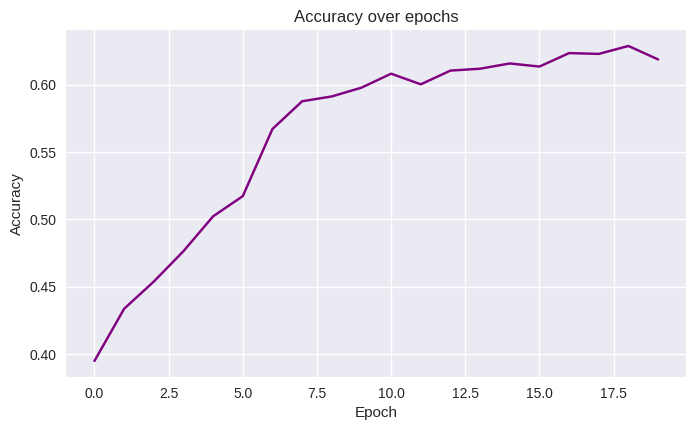

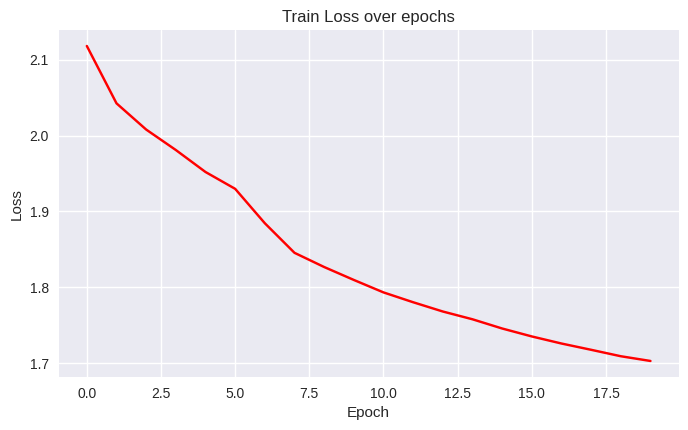

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')
accuracy = np.array(accs) 
fig, ax = plt.subplots(figsize = (8, 4.5))
ax.plot(accuracy, color='purple', label='Model Accuracy') 
ax.set(title="Accuracy over epochs", 
        xlabel='Epoch',
        ylabel='Accuracy') 


loss_list = np.array(losses) 
fig, ax = plt.subplots(figsize = (8, 4.5))
ax.plot(loss_list, color='red', label='Loss') 
ax.set(title="Train Loss over epochs", 
        xlabel='Epoch',
        ylabel='Loss') 

O Modelo que construimos no PyTorch tem perfomance extremamente semelhante ao que construimos do zero, possui uma precisão máxima de validação em torno de 62%, mesma precisão alcançada no modelo construido com a Airi.

Agora que utilizaremos o PyTorch, não precisaremos mais nos preocupar em toda parte de cálculo, derivadas e backward, veja que o framework fará todo este processo por debaixo dos panos!

Nossa tarefa agora é entender o que estes módulos fazem, quais devemos juntar, e como podemos construir modelos que consigam otimizar e aproximar as funções que desejamos. 

Indo muito além da classificação, os modelos de detecção, segmentação, dentre muitas outras tarefas, utilizam os mesmos módulos que vimos e vários outros em conjunto. 

Entender o processo é importante, mas não é necessário conhecer todas as funções e suas derivadas, agora que já sabemos como tudo é feito, basta entendermos qual a proposta do módulo, o que ele faz, e como ele interage com os demais.